In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, mean_absolute_percentage_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
plt.style.use('classic')

import warnings
warnings.filterwarnings("ignore")

Набор данных суперсимметрии поддерживает двоичную классификацию событий столкновений в физике элементарных частиц на основе собранных особенностей столкновений. Попробуем научиться предсказывать вид события в зависимости от физических параметров частиц после столкновения.

Данные состоят из следующих функций:

- `target class` : метки классов, где 0 - фоновое событие, 1 - суперсимметричное событие.
- `L1pT` : импульс, поперечный лучу лептона 1
- `L1eta` : псевдобыстрота лептона 1
- `L1phi` : азимутальный угол лептона 1
- `L2pT` : импульс, поперечный лучу лептона 2
- `L2eta` : псевдобыстрота лептона 2
- `L2phi` : азимутальный угол лептона 2
- `missing energy magnitude` : количество недостающего поперечного импульса
- `missing energy phi` : азимутальный угол недостающего поперечного импульса
Остальные 10 признаков получены из первых 8 непосредственно измеренных признаков. Эти последние 10 функций — это функции, которые физики элементарных частиц разработали для улучшения своей задачи по обнаружению событий. Подробнее про оригинальное исследование можете посмотреть в прикрепленной статье.

Суперсимметрия — это теоретическая основа физики элементарных частиц, которая предлагает принцип симметрии, связывающий фермионы (частицы с полуцелым спином) и бозоны (частицы с целым спином). Эта инновационная теория вводит концепцию суперсимметричного партнера для каждой известной элементарной частицы, которая отличается по спину на 1/2, но имеет другие фундаментальные свойства, такие как заряд и масса.

План работы следующий:  

1.   Предвартельный анализ данных
2.   Предобработка данных
      -   Обработка пропусков
      -   Обработка выбросов

3.   Реализация моделей
      -  Дерево
      -  Логистическая регрессия
      -  KNN

#### 1. Предварительный анализ данных
В этом разделе ожидается, посмотрим на распределение признаков и классов, изучим их связь, проанализируем признаки на наличие в них пропусков или выбросов.

In [7]:
df = pd.read_csv('hw5_phds_phys_data.csv')
df.isna().sum()   # анализ на наличие пропусков

target class                    0
L1pT                        29719
L1eta                           0
L1phi                           0
L2pT                            0
L2eta                           0
L2phi                           0
missing energy magnitude        0
missing energy phi              0
MET_rel                         0
axial MET                       0
M_R                             0
M_TR_2                      30024
R                               0
MT2                             0
S_R                             0
M_Delta_R                       0
dPhi_r_b                        0
cos(theta_r1)                   0
dtype: int64

In [9]:
X = df.drop('target class',axis=1)
y = df[['target class']]
needed_columns = X.columns.tolist()

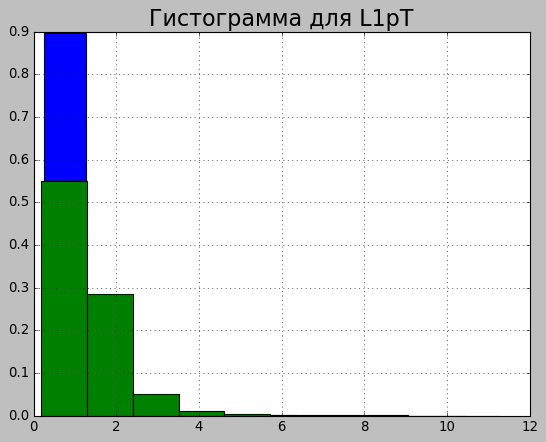

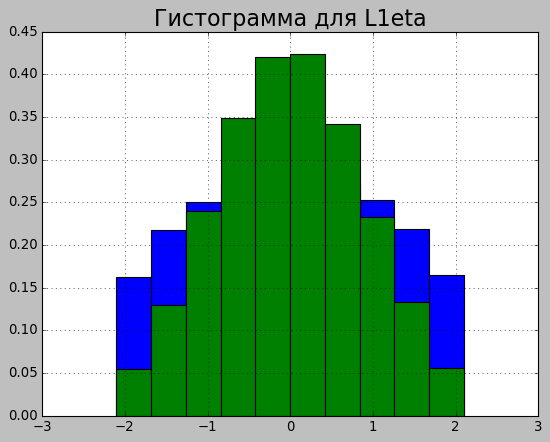

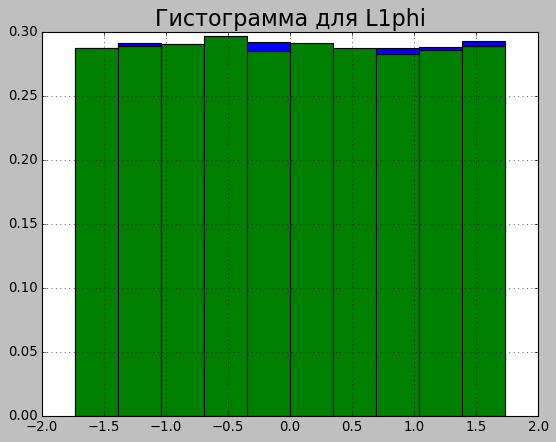

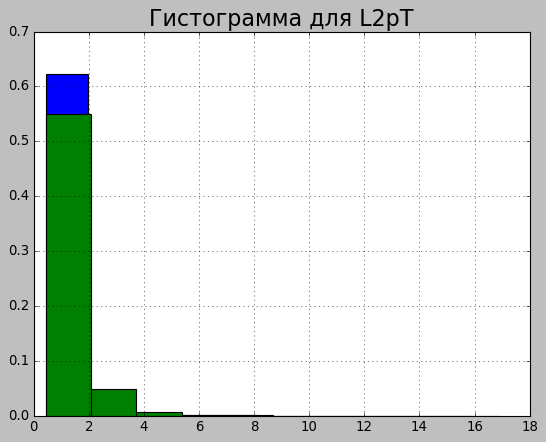

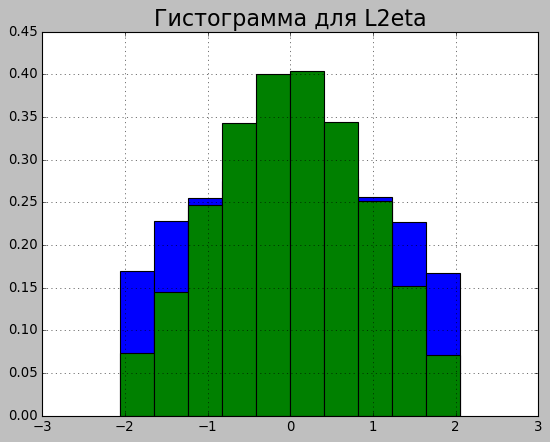

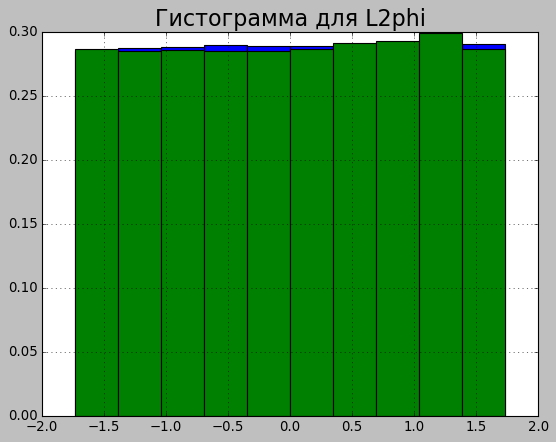

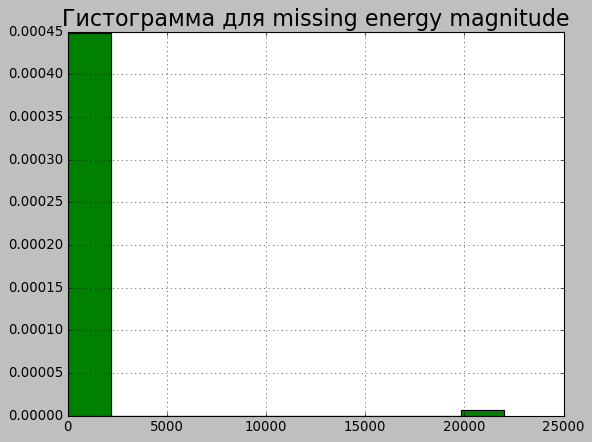

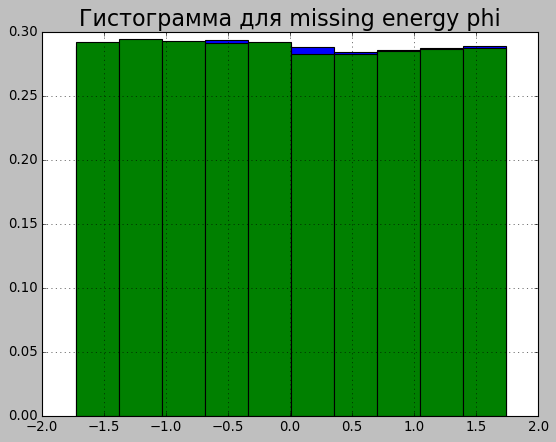

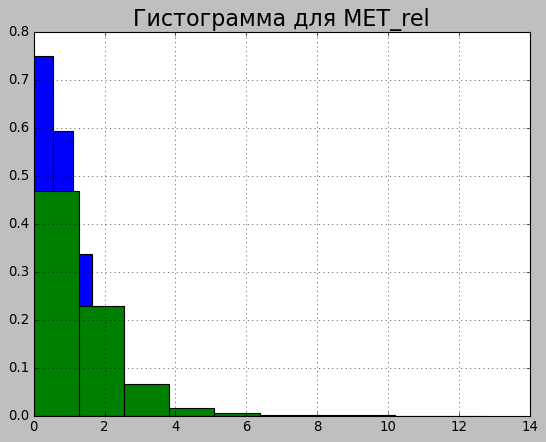

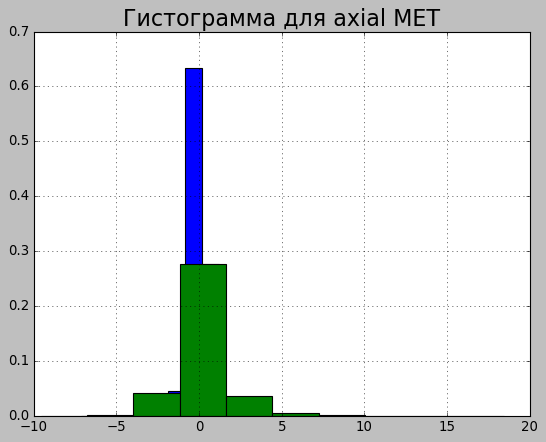

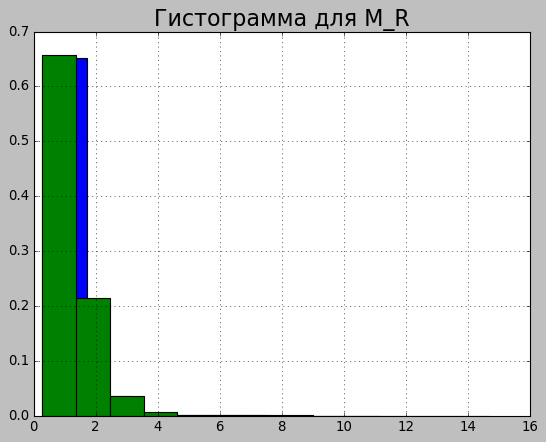

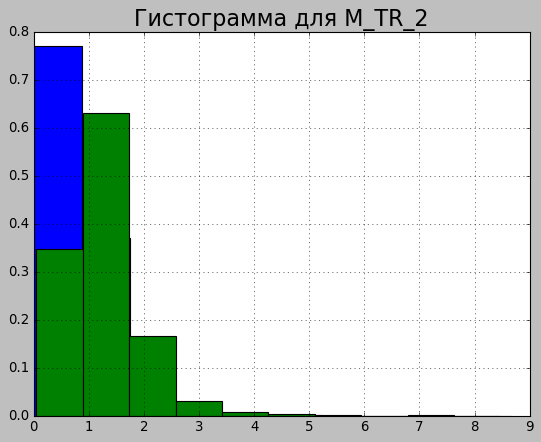

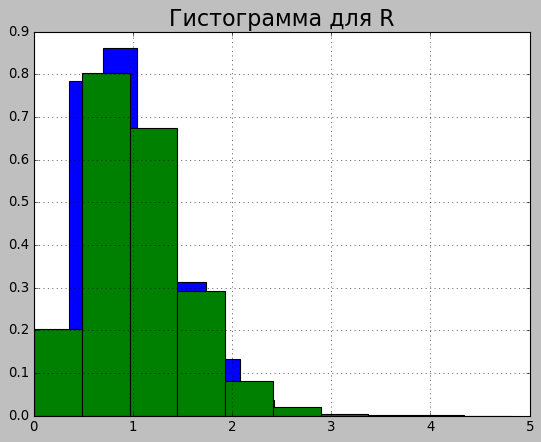

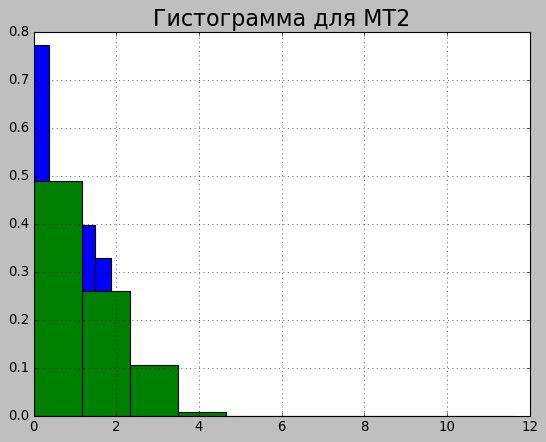

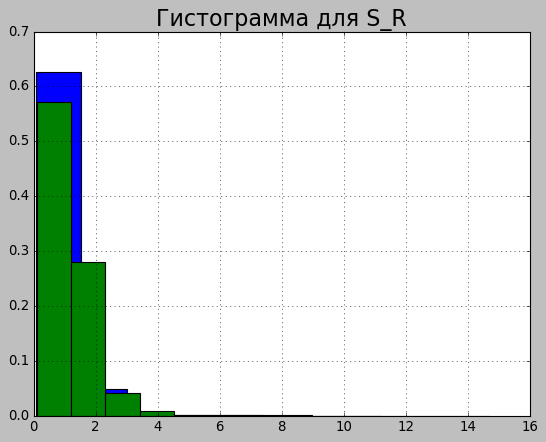

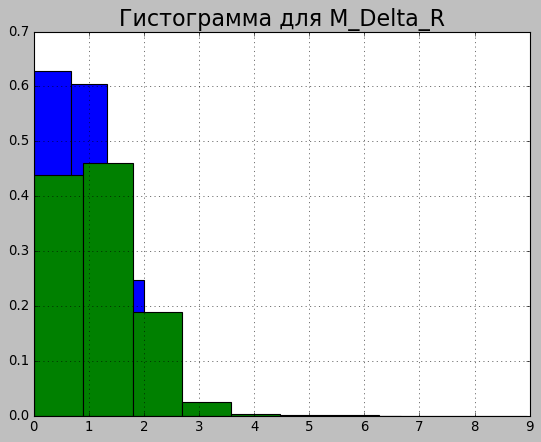

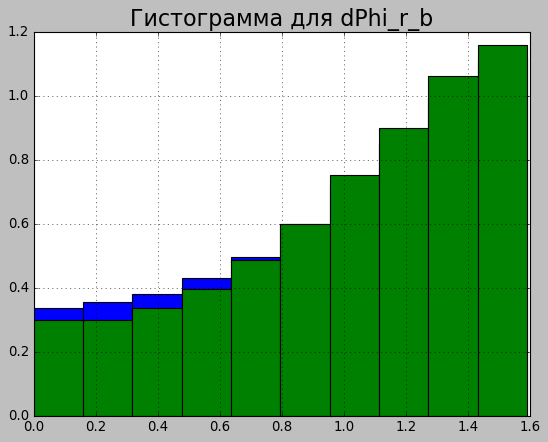

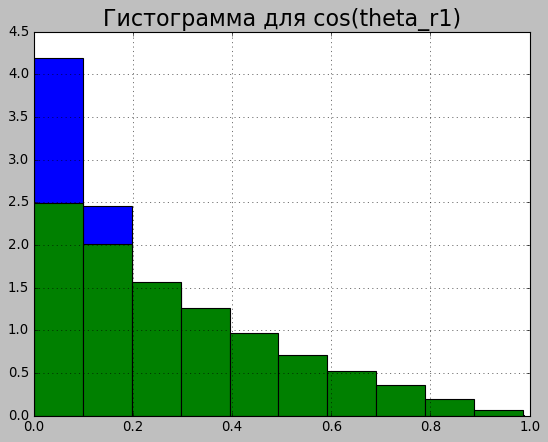

In [11]:
# смотрим на распределение признаков и классов
for el in needed_columns:
    df.groupby("target class")[el].hist(density=True)
    plt.title(f'Гистограмма для {el}', fontsize=20)
    plt.show()

На графиках выше можем увидеть примерные формы распределения для данных из каждого столбца. Наблюдаем и равномерное (L1phi), и нормальное (L1eta), и нормальное скошенное (что-то по типу R или M_TR_2), и экспоненциальное (cos(theta_r1)) распределения. По гистограммам можно судить о наличии выбросов лишь в параметре missing energy magnitude (значение признака подскакивает до 20000, когда в норме значение по модулю обычно не превосходило даже 2).(анализ на наличие выбросов)

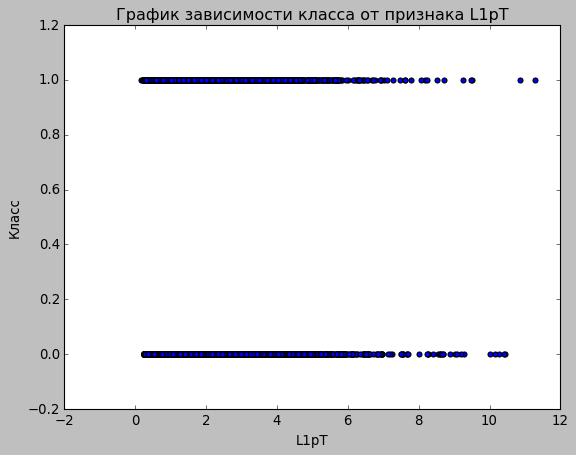

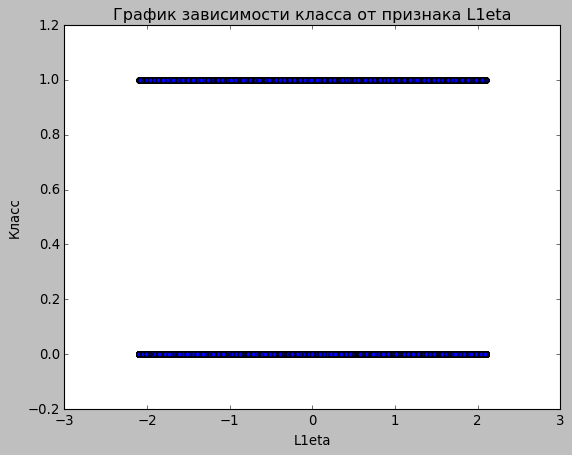

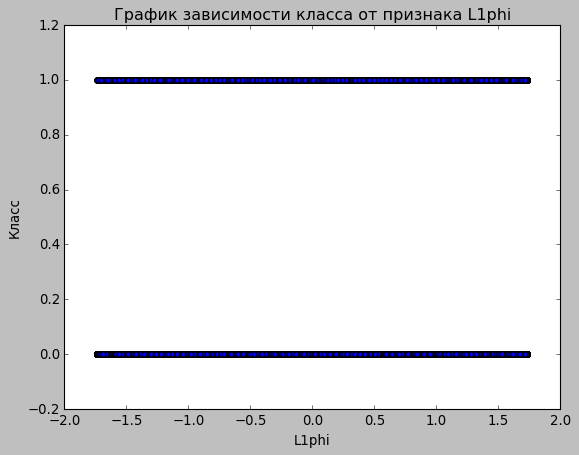

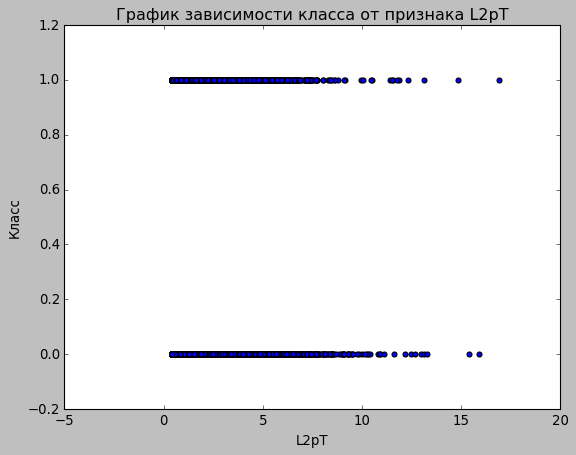

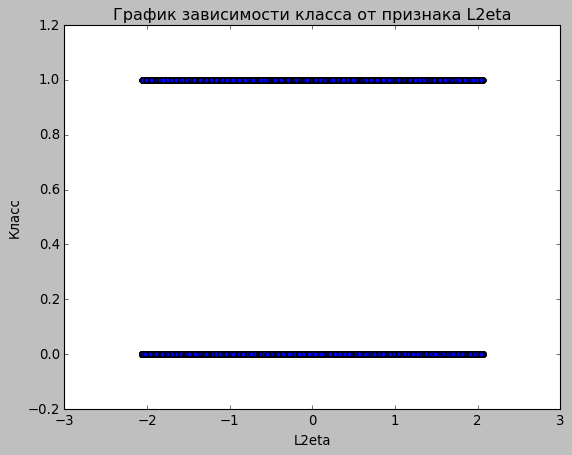

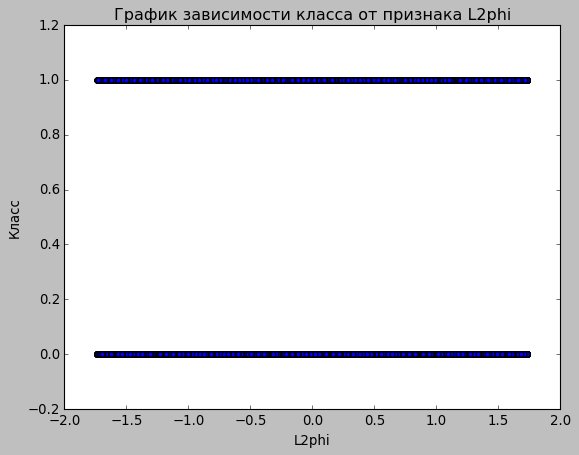

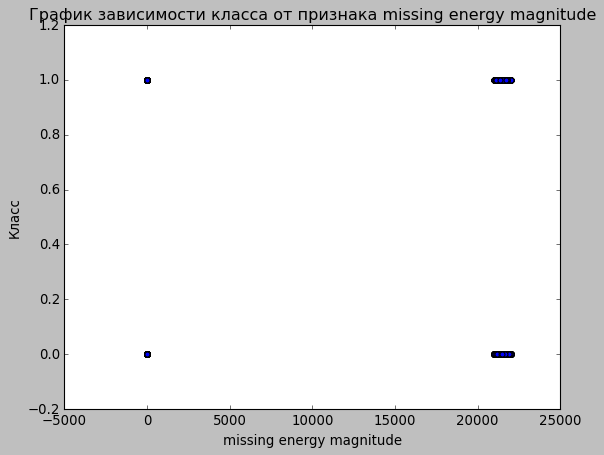

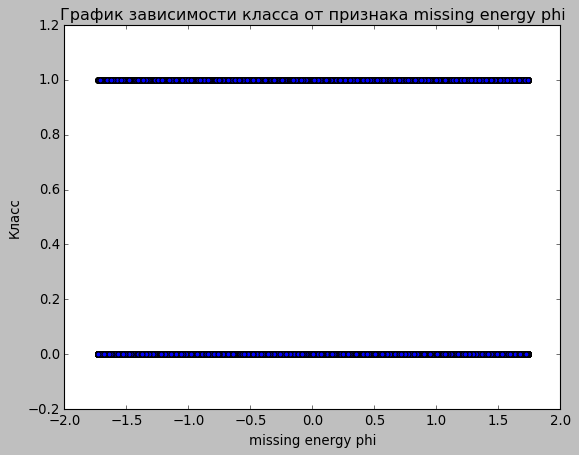

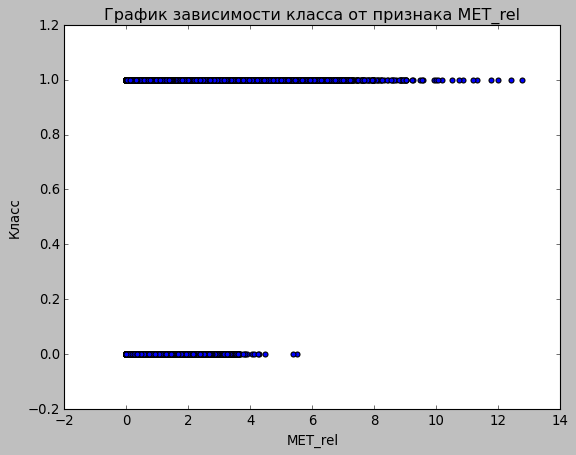

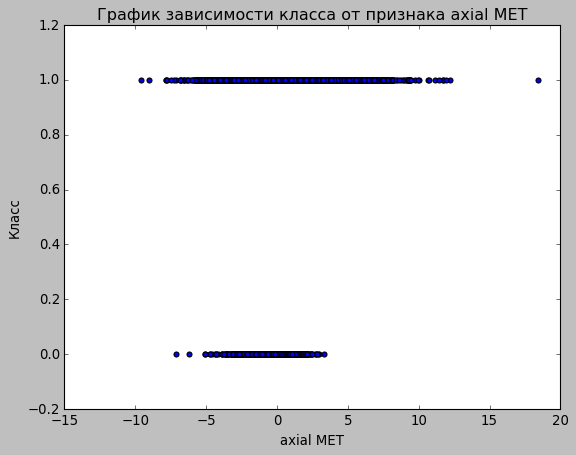

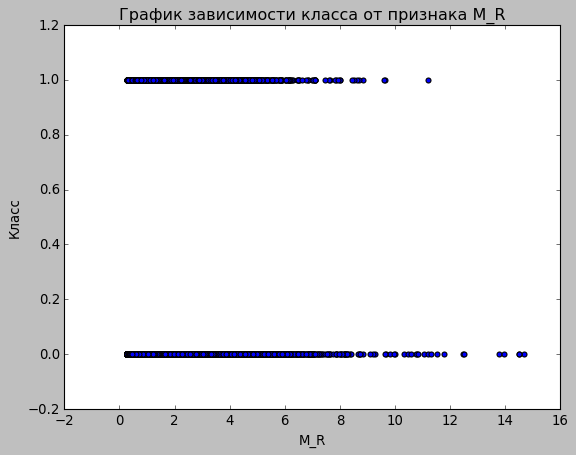

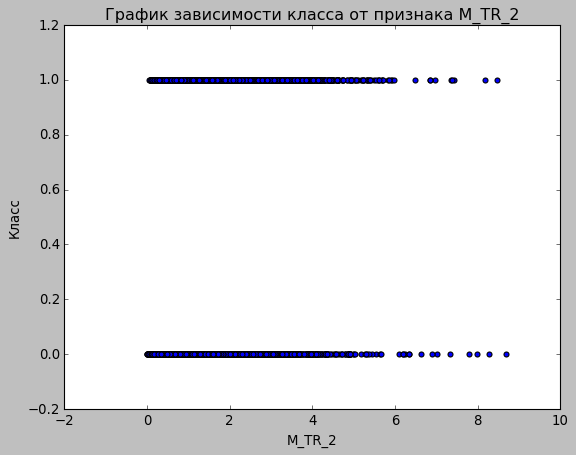

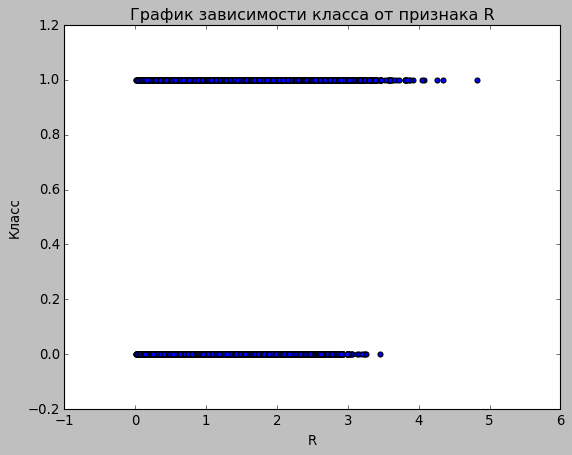

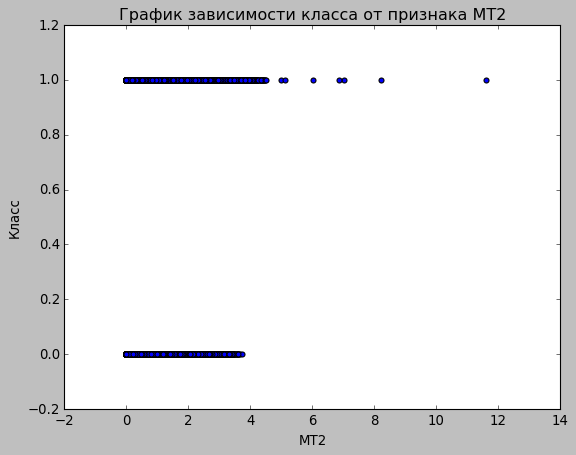

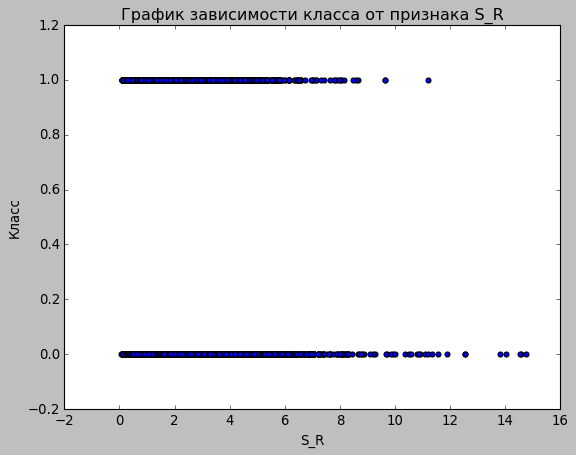

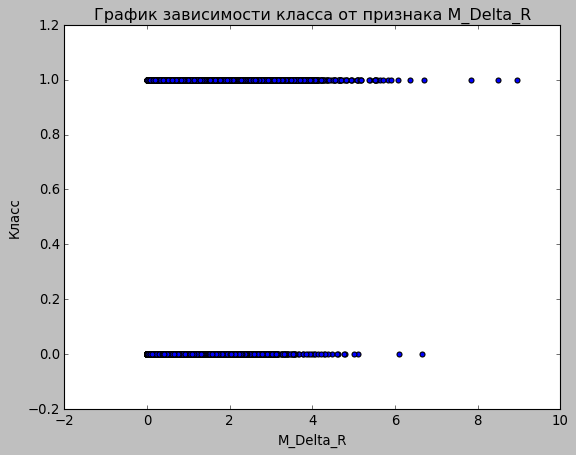

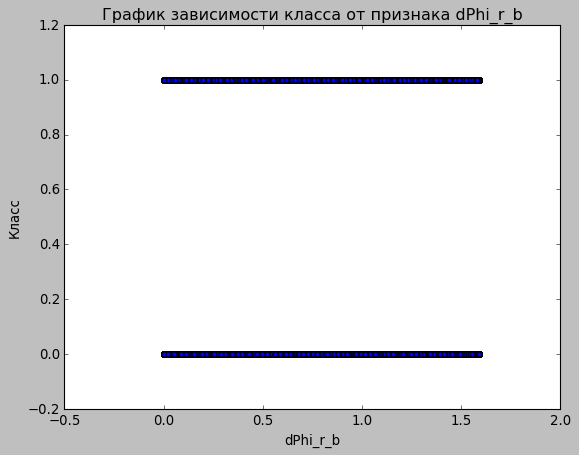

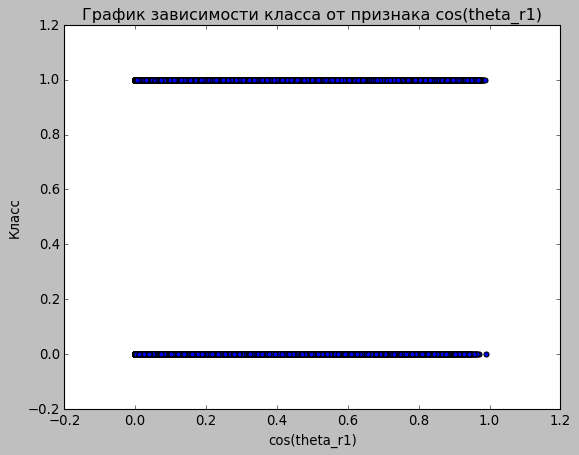

In [14]:
for i in range(len(needed_columns)):
    x = X[[needed_columns[i]]]
    plt.scatter(x, y)
    plt.xlabel(needed_columns[i]) 
    plt.ylabel('Класс') 
    plt.title(f'График зависимости класса от признака {needed_columns[i]}')
    plt.show()

Видим, что невооруженным глазом сложно разделить классы, хотя на некоторых графиках имеются места сосредоточения точек, принадлежащих лишь к одному классу.

In [16]:
corr_matrix = df.corr()   # анализ связей признаков
corr_matrix

,target class,L1pT,L1eta,L1phi,L2pT,L2eta,L2phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
target class,1.000000,0.306353,-0.001897,-0.001750,0.167477,0.001658,0.002229,0.000593,-0.002412,0.273337,0.087071,0.220369,0.348003,0.087516,0.068108,0.211631,0.238136,0.024497,0.229048
L1pT,0.306353,1.000000,-0.000952,-0.002309,0.789345,0.000081,-0.000421,0.001468,-0.002174,0.078402,-0.051881,0.823943,0.638108,-0.257428,-0.034731,0.804057,0.160692,-0.142961,0.062982
L1eta,-0.001897,-0.000952,1.000000,0.003067,-0.001865,0.420232,0.001415,-0.000820,-0.002043,0.000174,-0.001337,-0.001522,0.001119,0.000941,0.001397,-0.001397,0.001044,-0.000566,0.000147
L1phi,-0.001750,-0.002309,0.003067,1.000000,-0.001283,0.001303,-0.268214,-0.002468,-0.207490,0.000816,-0.001547,-0.001298,0.000009,-0.000703,0.000620,-0.001043,0.000238,0.002390,-0.000195
L2pT,0.167477,0.789345,-0.001865,-0.001283,1.000000,-0.000851,0.001161,0.000276,-0.004730,-0.026834,0.064133,0.799748,0.419616,-0.342738,-0.110868,0.798905,0.002303,-0.023648,-0.224284
L2eta,0.001658,0.000081,0.420232,0.001303,-0.000851,1.000000,0.001526,-0.001461,-0.000228,-0.000239,0.001193,-0.000414,-0.000281,-0.001375,-0.000582,-0.000619,-0.001052,-0.002192,0.000700
L2phi,0.002229,-0.000421,0.001415,-0.268214,0.001161,0.001526,1.000000,0.000283,-0.065115,0.002423,-0.000912,0.000039,0.001955,0.002639,0.001278,0.000364,0.000547,0.005565,-0.000167
missing energy magnitude,0.000593,0.001468,-0.000820,-0.002468,0.000276,-0.001461,0.000283,1.000000,-0.000544,-0.001131,-0.001047,0.002080,0.000669,-0.001800,-0.001208,0.001870,0.000055,-0.002087,0.000231
missing energy phi,-0.002412,-0.002174,-0.002043,-0.207490,-0.004730,-0.000228,-0.065115,-0.000544,1.000000,-0.005451,-0.003376,-0.002583,-0.003381,0.000446,-0.000244,-0.002970,-0.002240,-0.003506,0.003330
MET_rel,0.273337,0.078402,0.000174,0.000816,-0.026834,-0.000239,0.002423,-0.001131,-0.005451,1.000000,-0.290840,0.041235,0.638686,0.620135,0.632340,0.102249,0.773015,0.387591,0.307932


Выведем корреллирующие признаки (только те, у которых коэффициент коррелляции более чем 0.6)

In [20]:
rows, cols = np.where(np.triu(corr_matrix.abs() > 0.6, k=1))

for r, c in zip(rows, cols):
    print(f"{corr_matrix.columns[r]} & {corr_matrix.columns[c]}: {corr_matrix.iloc[r, c]:.2f}")

L1pT & L2pT: 0.79
L1pT & M_R: 0.82
L1pT & M_TR_2: 0.64
L1pT & S_R: 0.80
L2pT & M_R: 0.80
L2pT & S_R: 0.80
MET_rel & M_TR_2: 0.64
MET_rel & R: 0.62
MET_rel & MT2: 0.63
MET_rel & M_Delta_R: 0.77
M_R & S_R: 0.99
M_TR_2 & M_Delta_R: 0.71
R & MT2: 0.61
R & cos(theta_r1): 0.61
MT2 & M_Delta_R: 0.87


**Выводы:** В данном пункте были получены следующие ответы на поставленные вопросы:  
 1) **Пропуски:** пропуски имеются только в столбцах L1pT и M_TR_2, причем их количество порядка 30000 (если даже все пропуски находятся в одинаковых строках, то это порядка 10% всех данных, поэтому просто удалять эти строки не следует)
 2) **Распределение признаков и таргета:** как уже было сказано ранее, разные признаки распределены по-разному, в основном все-таки распределения имеют нормальный, равномерный или экспоненциальный вид (или что-то подобное, например скошенное нормальное распределение, когда происходит отклонение распределения от своего симметричного аналога).
 3) **Связь признаков друг с другом и с таргетом:** корреллирующие по моему мнению (из-за параметра 0.6, возможно кому-то покажется это число маленьким, чтобы считать признаки корреллирующими) представлены выше, есть даже признаки M_R и S_R, корреллирующие почти на 100%. Судя по полученным данным, велик шанс столкнуться с мультиколинеарностью, что означает для нас использование L1-регуляризации для модели логистической регрессии (или, скорее, комбинированной).
 4) **Выбросы:** наблюдаются очевидно только для признака missing energy magnitude. В целом мы мало что говорили о том, что делать с выбросами на практике. Есть метод z-score, который убирает все данные, не попадающие в диапазон +-$3\sigma$. Попробуем воспользоваться им далее для убирания выбросов только для признака missing energy magnitude.

#### 2. Предобработка данных
В этом разделе обработаем пропуски и выбросы. Для оценки качества обработки пропусков используем метрику MAPE.   
Для начала определимся с методами, с помощью которых будет осуществляться предобработка данных:  
 1) Для пропусков в колонках L1pT и M_TR_2 воспользуемся линейной регрессией.
 2) Для обработки выбросов в значениях параметра missing energy magnitude воспользуемся методом z-score.  
Теперь посчитаем метрику MAPE на заполненных данных с помощью KFold, чтобы проверить насколько хорошая идея - заполнять пропуски линейной регрессией:

In [24]:
def kfold_mape(
    df: pd.DataFrame,
    target_column: str,
):
    known_data = df[df[target_column].notna()].copy()
    features = df.select_dtypes(include=[np.number]).drop(target_column, axis=1)
    features["Intercept"] = 1   #  танцы с добавлением свободного члена потому что забыл про fit_intercept=True, потом вспомнил, но не охота менять код
    kf = KFold(n_splits=5, shuffle=True, random_state=52)
    mape_scores = []
    
    for train_idx, test_idx in kf.split(known_data):
        X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
        y_train = known_data.iloc[train_idx][target_column]
        
        model = LinearRegression(fit_intercept=False)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        mape = mean_absolute_percentage_error(
            known_data.iloc[test_idx][target_column],
            y_pred
        )
        mape_scores.append(mape)
    
    
    return np.mean(mape_scores)
print("MAPE:", kfold_mape(X.dropna(), 'L1pT'))
print("MAPE:", kfold_mape(X.dropna(), 'M_TR_2'))

MAPE: 0.13504377587248123
MAPE: 0.09946654348513509


Как видим, метрики не очень большие, что означает, что заполнение пропусков линейной регрессией сработает хорошо.  
Теперь собственно заполним реальные пропуски

In [27]:
X = df.drop('target class',axis=1)
def fill_na(df, target_column, n):
    known_data = df[df[target_column].notna()]
    missing_data = df[df[target_column].isna()]
    
    features = df.select_dtypes(include=[np.number]).columns.drop(target_column)
    
    if n == 2:
        X_1 = known_data[features]
        X_1 = X_1.drop('M_TR_2', axis=1)
        X_missing = missing_data[features].drop('M_TR_2', axis=1)
    
    else:
        X_1 = known_data[features]
        X_missing = missing_data[features]
    
    y_1 = known_data[target_column]
    model = LinearRegression()
    model.fit(X_1, y_1)
    
    predicted_values = model.predict(X_missing)
    
    df.loc[df[target_column].isna(), target_column] = predicted_values    
    return df
X_filled = fill_na(X, 'L1pT', 2)
X_filled = fill_na(X, 'M_TR_2', 1)
X_filled.isna().sum()

L1pT                        0
L1eta                       0
L1phi                       0
L2pT                        0
L2eta                       0
L2phi                       0
missing energy magnitude    0
missing energy phi          0
MET_rel                     0
axial MET                   0
M_R                         0
M_TR_2                      0
R                           0
MT2                         0
S_R                         0
M_Delta_R                   0
dPhi_r_b                    0
cos(theta_r1)               0
dtype: int64

А теперь удалим выбросы методом z-score:

In [32]:
def remove_outliers_zscore(df: pd.DataFrame, column: str) -> pd.DataFrame:
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    filtered_df = df[abs(z_scores) <= 3]
    return filtered_df
X_cleaned = remove_outliers_zscore(X_filled, 'missing energy magnitude')
X_cleaned

,L1pT,L1eta,L1phi,L2pT,L2eta,L2phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.712592,0.776299,-0.977246,0.775582,0.546116,0.622289,0.282914,-0.637910,0.240377,0.594836,0.618827,0.399519,0.572907,0.000000,0.602655,0.057377,1.006094,0.005815
1,1.892328,-0.483967,0.856761,1.583623,0.419065,-1.217196,0.450840,-0.720053,0.525133,-0.129555,1.681192,1.076764,0.568355,1.079640,1.620158,1.083848,0.085631,0.200274
2,0.794814,-0.449250,-0.442333,0.661218,0.421613,0.360242,1.526186,-1.558715,0.622938,-0.883875,0.698650,1.359658,1.726974,2.710943,0.811192,2.078608,1.187547,0.222146
3,1.022095,-1.819581,-1.527694,1.699453,-0.942580,-0.161568,0.766020,1.256380,1.092142,-0.286909,1.203704,1.112944,0.820481,1.593700,1.216380,1.201468,0.990246,0.094413
4,1.101241,-1.554862,0.663383,0.738752,1.810270,-0.956134,0.673655,-0.281957,0.945816,0.303187,2.818509,0.813961,0.256272,0.000000,2.819245,0.869279,0.848179,0.022044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.532496,-1.515373,0.840178,0.502648,-0.284088,-0.999418,0.667339,-0.478717,0.803635,-0.269342,0.546639,0.664760,1.079147,0.473644,0.587943,0.643448,1.411670,0.278707
299996,0.761094,-0.568073,-0.468213,1.259087,-1.813028,0.642755,0.608142,-1.677637,0.912896,-0.293763,1.030699,0.944297,0.813003,1.738531,1.020955,1.297669,0.153387,0.011885
299997,0.369419,1.159707,1.093901,0.619825,0.446000,-0.679366,0.486616,0.286263,0.727090,-0.164891,0.420325,0.484906,1.023736,0.277634,0.445195,0.472508,1.582718,0.037717
299998,0.520570,-0.878322,0.091014,0.551331,0.568090,-1.698432,0.712711,-0.086702,0.350892,0.944697,0.613005,0.551866,0.798889,0.226914,0.625680,0.392173,1.456143,0.160960


#### 3. Обучение моделей

In [35]:
#для теста используйте 30% выборки, размер валидационной выборки выберите на ваше усмотрение
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=52)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.4, random_state=52)  # Учитывая, что во всех случаях я использую Stratified KFold из-за дизбаланса классов и большего объема данных, на которых оценивается качество, я всегда буду обучать CV на X_tr, y_tr

##### DecisionTreeClassifier

Подберем оптимальные параметры для дерева с помощью RandomizedSearchCV, в качестве стратегии возьмем Stratified KFold (чтобы учесть распределение классов при разбиении данных и оценивать качество модели на всех данных, а значит будем брать данные из X_tr, y_tr), а в качестве метрики возьмем ROC-AUC для учета неравномерности классов и важности угадывания принадлежности к классам в целом:

In [39]:
# словарь параметров
parameters_grid = {
    'min_samples_leaf': [i for i in range(1, 30)], 'max_depth': [i for i in range(1, 30)], 'min_samples_split': [i for i in range(2, 30)], 'max_features': [i for i in range(1, 30)]
}

# задаем стратегию кросс-валидации
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)

# задаем имя метрики для максимизации, str
scorer_name = 'roc_auc'

# задаем модель
model = DecisionTreeClassifier()

 # определяем поиск по сетке
search = RandomizedSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # сколько комбинаций признаков будет проверено
    n_iter = 5,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)
search.fit(X_tr, y_tr)
search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'min_samples_split': 8,
 'min_samples_leaf': 18,
 'max_features': 11,
 'max_depth': 8}

In [40]:
clf = DecisionTreeClassifier(random_state=52, max_depth=search.best_params_['max_depth'], min_samples_leaf=search.best_params_['min_samples_leaf'], max_features=search.best_params_['max_features'], min_samples_split=search.best_params_['min_samples_split'])
clf.fit(X_tr, y_tr)
#  убрал визуализацию дерева так как она совсем не информативна на глубине 8
print('test precision:', precision_score(y_test, clf.predict(X_test)))
print('test f1-score:', f1_score(y_test, clf.predict(X_test)))
print('test recall:', recall_score(y_test, clf.predict(X_test)))
print('test ROC-AUC:', roc_auc_score(y_test, clf.predict(X_test)))

test precision: 0.8316820276497696
test f1-score: 0.5803754472002252
test recall: 0.4456998209544977
test ROC-AUC: 0.7129519388500792


**Выводы:** По полученным значениям метрики можем сказать следующее:  
1) Значение precision порядка 0.8 показывает, что если модель относит объект к классу 1, то она это делает с 80% точностью. Это достаточно хороший результат, но есть нюанс, который виден по значению recalla
2) Полученный recall 0.5, а значит лишь половина объектов отнесена к классу 1. По идее для нашей задачи это приемлемо (ведь никто не умрет, если мы неправильно классифицируем столкновение частиц), но все же значение довольно низкое
3) В целом разделение классов, которое описывает значение ROC-AUC - 0.7. Величина довольно большая, модель ошибается 1 раз из 4, что в купе с точностью 80% по угадыванию 1 класса дает высокие результаты.

##### LogisticRegression

In [43]:
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr, y_train)
X_test = scaler.transform(X_test)
parameters_grid = {
    'C': np.logspace(-4, 2, 10), 
    'l1_ratio': np.arange(0, 1, 0.01)
}

# задаем стратегию кросс-валидации
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)

# задаем имя метрики для максимизации, str
scorer_name = 'precision'

# задаем модель
model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', fit_intercept=False, max_iter = 100)

 # определяем поиск по сетке
search = RandomizedSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # сколько комбинаций признаков будет проверено
    n_iter = 5,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)
search.fit(X_tr, y_tr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=52, shuffle=True),
                   error_score='raise',
                   estimator=LogisticRegression(fit_intercept=False,
                                                penalty='elasticnet',
                                                solver='saga'),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883...
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
                   scoring='precision', verbose=10)

In [44]:
model = LogisticRegression(penalty='elasticnet', C=search.best_params_['C'], solver='saga', max_iter=100, l1_ratio=search.best_params_['l1_ratio'])
model.fit(X_tr, y_tr)
print('test precision:', precision_score(y_test, model.predict(X_test)))
print('test f1-score:', f1_score(y_test, model.predict(X_test)))
print('test recall:', recall_score(y_test, model.predict(X_test)))
print('test ROC-AUC:', roc_auc_score(y_test, model.predict(X_test)))

test precision: 0.7722483178875206
test f1-score: 0.5053584780260862
test recall: 0.3755633759338149
test ROC-AUC: 0.6756277104863172


**Выводы:** По полученным значениям метрики можем сказать следующее:  
1) Значение precision порядка 0.8 показывает, что если модель относит объект к классу 1, то она это делает с 80% точностью. Это достаточно хороший результат, но есть нюанс, который виден по значению recalla
2) Полученный recall 0.4, а значит меньше половины объектов отнесена к классу 1. Это значение меньше, чем у дерева, а значит в этом плане дерево побеждает.
3) В целом разделение классов, которое описывает значение ROC-AUC - 0.7. По аналогии с деревом, но только чуть меньше.
В целом видим, что некритично, но логрег проигрывает. Интересно заметить, что по мнению RandomizedSearchCV лучшая модель - L1-регрессия с максимальным C. Скорее всего это вызвано мультиколлинеарностью в наших данных.

##### KNeighborsClassifier

In [72]:
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr, y_train)
X_test = scaler.transform(X_test)
parameters_grid = {
    'n_neighbors': [i for i in range(1, 15)]
}

# задаем стратегию кросс-валидации
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)

# задаем имя метрики для максимизации, str
scorer_name = 'roc_auc'

# задаем модель
model = KNeighborsClassifier()

search = GridSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)
search.fit(X_tr, y_tr)
search.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


{'n_neighbors': 14}

In [85]:
model = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'])
model.fit(X_tr, y_tr)
y_pred = model.predict(X_test)
print('test precision:', precision_score(y_test, y_pred))
print('test f1-score:', f1_score(y_test, y_pred))
print('test recall:', recall_score(y_test, y_pred))
print('test ROC-AUC:', roc_auc_score(y_test, y_pred))

test precision: 0.8655284323409059
test f1-score: 0.526885414877169
test recall: 0.37871210718034204
test ROC-AUC: 0.6828996764781295


**Выводы:** По полученным значениям метрики можем сказать следующее:  
1) Значение precision порядка 0.87. Это самый лучший результат из всех трех, но все еще есть нюанс, который виден по значению recalla
2) Полученный recall 0.4, а значит меньше половины объектов отнесена к классу 1. Это значение так же меньше, чем у дерева, а значит в этом плане дерево побеждает.
3) В целом разделение классов, которое описывает значение ROC-AUC - 0.7. В этом плане модель не сильно отличается от дерева или логрега. При этом с ростом числа соседей метрики хоть и растут, но незначительно. А вот расчет оптимальных параметров занимает довольно много времени, поэтому разумно остановиться на 14 соседях.

#### 4. Анализ полученных результатов и выводы по задаче
**Выводы:** 
1) Важным шагом к получению высоких результатов является предобработка данных, причем в зависимости от выбранной стратегии могут получаться совершенно разные значения метрик
2) Оптимизация с помощью RandomizedSearchCV и GridSearchCV - очень долгий процесс. Для полученных дерева и логрега выводы уже расписаны, итоговый победитель - решающее дерево, которое хоть и с небольшим, но все-таки отрывом, имеет более высокие метрики.

Далее проведем все то же самое, но попробуем сбалансировать классы, удаляя часть "избыточных" данных

In [96]:
df = pd.read_csv('hw5_phds_phys_data.csv')
y = df[['target class']]
y.sum()/300000

target class    0.180617
dtype: float64

In [110]:
df_target_1 = df[df['target class'] == 1]
df_target_0 = df[df['target class'] == 0]
df_target_0_sampled = df_target_0.sample(n=50000, random_state=42)
df_target_0_sampled

,target class,L1pT,L1eta,L1phi,L2pT,L2eta,L2phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
240426,0.0,1.993868,0.171637,0.163204,3.191208,0.113673,-1.547623,0.293204,0.574832,0.294730,0.362842,2.035991,0.847543,0.369404,0.312327,2.044263,0.259265,1.216497,0.019165
209769,0.0,0.577939,0.058666,-0.572593,0.925360,0.940127,0.204432,0.768216,-1.506327,1.153187,-0.245868,0.676399,0.923714,1.211852,1.830718,0.657796,1.371047,0.793770,0.152592
61227,0.0,0.897062,-1.261501,1.490890,0.492450,-1.728109,0.324623,1.118335,-0.248171,1.455773,-0.755826,0.643279,1.172265,1.617119,1.254596,0.719511,1.005237,1.303634,0.650543
246396,0.0,0.353099,0.151055,0.787193,0.582510,0.126518,0.471461,0.403137,0.908550,0.125191,0.673553,0.365790,0.165849,0.402346,0.180541,0.126719,0.190814,0.624431,0.398043
139998,0.0,0.638413,0.192551,1.157864,1.017225,0.912513,-0.638903,0.260300,-1.434208,0.388045,0.544233,0.713675,0.440029,0.547138,0.000000,0.717565,0.191584,1.450464,0.017395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287841,0.0,0.681831,-0.952860,-0.608619,0.680704,-1.269353,1.660485,1.220864,0.738647,1.832668,-0.906537,0.579382,1.128086,1.727800,1.819874,0.696322,1.438399,1.550353,0.396979
135533,0.0,0.553449,-1.945012,0.805505,0.540348,-0.648972,-1.541147,0.639470,-0.178860,0.959921,-0.159961,0.588095,0.710232,1.071688,1.289609,0.606115,0.983135,1.041812,0.057413
81271,0.0,1.837903,-0.261053,0.944821,1.806700,1.172434,-0.647206,1.174664,-1.085848,1.273483,-0.835653,2.094811,1.667035,0.706183,1.259987,2.130634,1.478655,1.364436,0.165317
283834,0.0,0.714942,-1.490238,1.294441,0.867812,0.714752,-1.062153,0.201954,0.032392,0.303157,0.114254,1.277335,0.493711,0.342992,0.886896,1.253997,0.778162,0.033234,0.026647


In [128]:
combined_df = pd.concat([df_target_1, df_target_0_sampled])
X = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
X

,target class,L1pT,L1eta,L1phi,L2pT,L2eta,L2phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.368289,0.766835,1.139790,0.594770,-0.339217,0.350439,1.135325,-1.407744,1.704261,-0.487782,0.463360,0.891576,1.707481,1.750617,0.557702,1.361686,1.243151,0.254163
1,1.0,NaN,0.152332,-1.259061,2.640604,0.534347,0.592205,0.292496,1.106606,0.349459,0.316388,2.040913,NaN,0.364777,0.000000,2.019969,0.191588,0.407421,0.104799
2,1.0,NaN,0.603376,0.760030,0.633088,-1.195301,0.085320,1.389283,-1.265332,2.085485,-1.058961,0.964480,NaN,1.260903,2.677480,1.049455,2.124383,1.413170,0.185026
3,1.0,NaN,-1.165637,-1.227850,0.778199,-0.120714,0.007266,0.697960,0.844809,1.045503,-0.384097,0.826653,0.916371,1.017124,1.407131,0.839691,1.120988,1.391334,0.246487
4,0.0,0.616672,1.302662,-1.374373,0.899853,0.970822,0.709745,0.190009,-0.164484,0.285227,0.126044,0.612642,0.427138,0.618698,0.632225,0.603351,0.488572,0.067656,0.063751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104180,0.0,0.901676,-1.640290,-0.871896,0.985428,-0.712256,0.601541,0.266997,1.438011,0.399902,0.071322,0.890295,0.568495,0.566643,0.724890,0.881633,0.569668,0.367882,0.110236
104181,0.0,0.509708,-0.086769,1.322991,0.750152,-1.288507,-0.621402,0.092969,-1.202352,0.057385,0.390702,0.638795,0.217453,0.302079,0.000000,0.634103,0.088010,0.382261,0.030827
104182,0.0,4.386986,-0.813025,-0.471701,3.110356,0.765777,0.889109,0.537098,-1.337137,0.352295,0.114034,4.615004,1.588699,0.305482,2.403663,4.414016,2.570668,0.179513,0.101723
104183,1.0,NaN,-1.912738,0.739168,0.628037,1.188317,-1.181178,0.281564,-0.744133,0.297054,0.097633,1.344460,NaN,0.262754,0.362839,1.352213,0.366166,1.289676,0.017356


In [130]:
def remove_outliers_zscore(df: pd.DataFrame, column: str) -> pd.DataFrame:
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    filtered_df = df[abs(z_scores) <= 3]
    return filtered_df
X_cleaned = remove_outliers_zscore(X, 'missing energy magnitude')
X_cleaned

,target class,L1pT,L1eta,L1phi,L2pT,L2eta,L2phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.368289,0.766835,1.139790,0.594770,-0.339217,0.350439,1.135325,-1.407744,1.704261,-0.487782,0.463360,0.891576,1.707481,1.750617,0.557702,1.361686,1.243151,0.254163
1,1.0,NaN,0.152332,-1.259061,2.640604,0.534347,0.592205,0.292496,1.106606,0.349459,0.316388,2.040913,NaN,0.364777,0.000000,2.019969,0.191588,0.407421,0.104799
2,1.0,NaN,0.603376,0.760030,0.633088,-1.195301,0.085320,1.389283,-1.265332,2.085485,-1.058961,0.964480,NaN,1.260903,2.677480,1.049455,2.124383,1.413170,0.185026
3,1.0,NaN,-1.165637,-1.227850,0.778199,-0.120714,0.007266,0.697960,0.844809,1.045503,-0.384097,0.826653,0.916371,1.017124,1.407131,0.839691,1.120988,1.391334,0.246487
4,0.0,0.616672,1.302662,-1.374373,0.899853,0.970822,0.709745,0.190009,-0.164484,0.285227,0.126044,0.612642,0.427138,0.618698,0.632225,0.603351,0.488572,0.067656,0.063751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104180,0.0,0.901676,-1.640290,-0.871896,0.985428,-0.712256,0.601541,0.266997,1.438011,0.399902,0.071322,0.890295,0.568495,0.566643,0.724890,0.881633,0.569668,0.367882,0.110236
104181,0.0,0.509708,-0.086769,1.322991,0.750152,-1.288507,-0.621402,0.092969,-1.202352,0.057385,0.390702,0.638795,0.217453,0.302079,0.000000,0.634103,0.088010,0.382261,0.030827
104182,0.0,4.386986,-0.813025,-0.471701,3.110356,0.765777,0.889109,0.537098,-1.337137,0.352295,0.114034,4.615004,1.588699,0.305482,2.403663,4.414016,2.570668,0.179513,0.101723
104183,1.0,NaN,-1.912738,0.739168,0.628037,1.188317,-1.181178,0.281564,-0.744133,0.297054,0.097633,1.344460,NaN,0.262754,0.362839,1.352213,0.366166,1.289676,0.017356


In [136]:
y = X_cleaned[['target class']]

In [138]:
X = X_cleaned.drop('target class',axis=1)
def fill_na(df, target_column, n):
    known_data = df[df[target_column].notna()]
    missing_data = df[df[target_column].isna()]
    
    features = df.select_dtypes(include=[np.number]).columns.drop(target_column)
    
    if n == 2:
        X_1 = known_data[features]
        X_1 = X_1.drop('M_TR_2', axis=1)
        X_missing = missing_data[features].drop('M_TR_2', axis=1)
    
    else:
        X_1 = known_data[features]
        X_missing = missing_data[features]
    
    y_1 = known_data[target_column]
    model = LinearRegression()
    model.fit(X_1, y_1)
    
    predicted_values = model.predict(X_missing)
    
    df.loc[df[target_column].isna(), target_column] = predicted_values    
    return df
X_filled = fill_na(X, 'L1pT', 2)
X_filled = fill_na(X, 'M_TR_2', 1)
X_filled.isna().sum()

L1pT                        0
L1eta                       0
L1phi                       0
L2pT                        0
L2eta                       0
L2phi                       0
missing energy magnitude    0
missing energy phi          0
MET_rel                     0
axial MET                   0
M_R                         0
M_TR_2                      0
R                           0
MT2                         0
S_R                         0
M_Delta_R                   0
dPhi_r_b                    0
cos(theta_r1)               0
dtype: int64

In [140]:
X_filled

,L1pT,L1eta,L1phi,L2pT,L2eta,L2phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.368289,0.766835,1.139790,0.594770,-0.339217,0.350439,1.135325,-1.407744,1.704261,-0.487782,0.463360,0.891576,1.707481,1.750617,0.557702,1.361686,1.243151,0.254163
1,1.972908,0.152332,-1.259061,2.640604,0.534347,0.592205,0.292496,1.106606,0.349459,0.316388,2.040913,0.986780,0.364777,0.000000,2.019969,0.191588,0.407421,0.104799
2,0.713080,0.603376,0.760030,0.633088,-1.195301,0.085320,1.389283,-1.265332,2.085485,-1.058961,0.964480,1.382327,1.260903,2.677480,1.049455,2.124383,1.413170,0.185026
3,0.698718,-1.165637,-1.227850,0.778199,-0.120714,0.007266,0.697960,0.844809,1.045503,-0.384097,0.826653,0.916371,1.017124,1.407131,0.839691,1.120988,1.391334,0.246487
4,0.616672,1.302662,-1.374373,0.899853,0.970822,0.709745,0.190009,-0.164484,0.285227,0.126044,0.612642,0.427138,0.618698,0.632225,0.603351,0.488572,0.067656,0.063751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104180,0.901676,-1.640290,-0.871896,0.985428,-0.712256,0.601541,0.266997,1.438011,0.399902,0.071322,0.890295,0.568495,0.566643,0.724890,0.881633,0.569668,0.367882,0.110236
104181,0.509708,-0.086769,1.322991,0.750152,-1.288507,-0.621402,0.092969,-1.202352,0.057385,0.390702,0.638795,0.217453,0.302079,0.000000,0.634103,0.088010,0.382261,0.030827
104182,4.386986,-0.813025,-0.471701,3.110356,0.765777,0.889109,0.537098,-1.337137,0.352295,0.114034,4.615004,1.588699,0.305482,2.403663,4.414016,2.570668,0.179513,0.101723
104183,0.654101,-1.912738,0.739168,0.628037,1.188317,-1.181178,0.281564,-0.744133,0.297054,0.097633,1.344460,0.509159,0.262754,0.362839,1.352213,0.366166,1.289676,0.017356


In [142]:
X_tr, X_test, y_tr, y_test = train_test_split(X_filled, y, test_size=0.3, random_state=52)

In [144]:
# словарь параметров
parameters_grid = {
    'min_samples_leaf': [i for i in range(1, 30)], 'max_depth': [i for i in range(1, 30)], 'min_samples_split': [i for i in range(2, 30)], 'max_features': [i for i in range(1, 30)]
}

# задаем стратегию кросс-валидации
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)

# задаем имя метрики для максимизации, str
scorer_name = 'roc_auc'

# задаем модель
model = DecisionTreeClassifier()

 # определяем поиск по сетке
search = RandomizedSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # сколько комбинаций признаков будет проверено
    n_iter = 5,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)
search.fit(X_tr, y_tr)
search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'min_samples_split': 23,
 'min_samples_leaf': 10,
 'max_features': 13,
 'max_depth': 13}

In [145]:
clf = DecisionTreeClassifier(random_state=52, max_depth=search.best_params_['max_depth'], min_samples_leaf=search.best_params_['min_samples_leaf'], max_features=search.best_params_['max_features'], min_samples_split=search.best_params_['min_samples_split'])
clf.fit(X_tr, y_tr)
#  убрал визуализацию дерева так как она совсем не информативна на глубине 8
print('test precision:', precision_score(y_test, clf.predict(X_test)))
print('test f1-score:', f1_score(y_test, clf.predict(X_test)))
print('test recall:', recall_score(y_test, clf.predict(X_test)))
print('test ROC-AUC:', roc_auc_score(y_test, clf.predict(X_test)))

test precision: 0.8301255801255801
test f1-score: 0.792713526900642
test recall: 0.7585282195198004
test ROC-AUC: 0.7949141029820773


Как видим, recall увеличился до 76%, что намного выше прошлых значений. Отсюда видим, что иногда перебалансировка классов может в лучшую сторону сказаться на разделении классов в целом.